In [1]:
#inviting guest to the party
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import re

from scipy import stats
from scipy.stats import skew
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

import sklearn.model_selection as ms
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from scipy.stats import norm



pd.set_option('display.max_columns',99)
pd.set_option('display.max_rows',300)

In [2]:
#import datasets
test_dataset = pd.read_csv('./test_dataset.csv')
train_dataset = pd.read_csv('./train_dataset.csv')

#add identifier for test and train data set
train_dataset['dataset'] = 'train'
test_dataset['dataset'] = 'test'

#get shape of train and test data set
print(f'train data set is {train_dataset.shape}')
print(f'test data set is {test_dataset.shape}')
merged_data = pd.concat([train_dataset, test_dataset], axis=0)
print(f'merged data set is {merged_data.shape}')

train data set is (91589, 51)
test data set is (10177, 51)
merged data set is (101766, 51)


In [3]:
#make a copy for data exploration
df = merged_data.copy(deep=True)


# EDA

### Exploration the target variable

In [4]:
#function to summarize feature
def summarize_feature(dataframe,feature):
    feature_summary = {'values':dataframe[feature].value_counts().index.tolist(),
                     'counts':dataframe[feature].value_counts().values.tolist(),
                     'frequency': dataframe[feature].value_counts(normalize = True).values.tolist()}
    feature_summary = pd.DataFrame(feature_summary)
    return feature_summary


In [5]:
print('\n'+'*'*10 +'readmitted original'+'*'*10)
print(summarize_feature(df, 'readmitted'))

#replace target variable with numerical value
df['readmitted'] = df['readmitted'].replace('<30', '1')
df['readmitted'] = df['readmitted'].replace('>30', '0')
df['readmitted'] = df['readmitted'].replace('NO', '0')

print('\n'+'*'*10 +'readmitted cleaned'+'*'*10)
print(summarize_feature(df, 'readmitted'))



**********readmitted original**********
  values  counts  frequency
0     NO   54864   0.539119
1    >30   35545   0.349282
2    <30   11357   0.111599

**********readmitted cleaned**********
  values  counts  frequency
0      0   90409   0.888401
1      1   11357   0.111599


### feature examination

In [6]:
#taking a look at all the features and their dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 10176
Data columns (total 51 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766

In [7]:
#converting all categorical numbers to str

df[['encounter_id','patient_nbr', 'admission_type_id','discharge_disposition_id', 'admission_source_id',]] = df[['encounter_id','patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id',]].astype(str)
      

### features one by one

#### encounter_id and patient_nbr are left alone for now

In [8]:
print('\n'+'*'*10 +'race original'+'*'*10)
print(summarize_feature(df, 'race'))

#replace ? with unknown
df.race = df.race.replace({'?':'unknown'})

print('\n'+'*'*10 +'race cleaned'+'*'*10)
print(summarize_feature(df, 'race'))



**********race original**********
            values  counts  frequency
0        Caucasian   76099   0.747784
1  AfricanAmerican   19210   0.188766
2                ?    2273   0.022336
3         Hispanic    2037   0.020017
4            Other    1506   0.014799
5            Asian     641   0.006299

**********race cleaned**********
            values  counts  frequency
0        Caucasian   76099   0.747784
1  AfricanAmerican   19210   0.188766
2          unknown    2273   0.022336
3         Hispanic    2037   0.020017
4            Other    1506   0.014799
5            Asian     641   0.006299


In [9]:
print('\n'+'*'*10 +'gender original'+'*'*10)
print(summarize_feature(df, 'gender'))

#only 3 unknown/invalid, drop rows
df = df[df.gender != 'Unknown/Invalid']

print('\n'+'*'*10 +'gender cleaned'+'*'*10)
print(summarize_feature(df, 'gender'))



**********gender original**********
            values  counts  frequency
0           Female   54708   0.537586
1             Male   47055   0.462384
2  Unknown/Invalid       3   0.000029

**********gender cleaned**********
   values  counts  frequency
0  Female   54708   0.537602
1    Male   47055   0.462398


In [10]:
print('\n'+'*'*10 +'age original'+'*'*10)
print(summarize_feature(df, 'age'))

#convert age feature
dict_age = {'[60-70)': '60-70', 
            '[40-50)':'40-50', 
            '[80-90)':'80-90',
               '[70-80)':'70-80',
               '[50-60)':'50-60',
               '[20-30)':'20-30',
               '[90-100)':'90-100',
               '[30-40)':'30-40',
               '[0-10)':'0-10',
               '[10-20)':'10-20'}
df.age.replace(dict_age, inplace=True)

print('\n'+'*'*10 +'age converted'+'*'*10)
print(summarize_feature(df, 'age'))



**********age original**********
     values  counts  frequency
0   [70-80)   26066   0.256144
1   [60-70)   22482   0.220925
2   [50-60)   17256   0.169570
3   [80-90)   17197   0.168991
4   [40-50)    9685   0.095172
5   [30-40)    3775   0.037096
6  [90-100)    2793   0.027446
7   [20-30)    1657   0.016283
8   [10-20)     691   0.006790
9    [0-10)     161   0.001582

**********age converted**********
   values  counts  frequency
0   70-80   26066   0.256144
1   60-70   22482   0.220925
2   50-60   17256   0.169570
3   80-90   17197   0.168991
4   40-50    9685   0.095172
5   30-40    3775   0.037096
6  90-100    2793   0.027446
7   20-30    1657   0.016283
8   10-20     691   0.006790
9    0-10     161   0.001582


In [11]:
print('\n'+'*'*10 +'weight original'+'*'*10)
print(summarize_feature(df, 'weight'))

#missing a lot of data, drop column
df = df.drop(['weight'], axis = 1)

print('\n'+'*'*10 +'weight cleaned'+'*'*10)
try:
    print(summarize_feature(df, 'weight'))
except:
    print('Feature does not exist')



**********weight original**********
      values  counts  frequency
0          ?   98566   0.968584
1   [75-100)    1336   0.013129
2    [50-75)     897   0.008815
3  [100-125)     625   0.006142
4  [125-150)     145   0.001425
5    [25-50)      97   0.000953
6     [0-25)      48   0.000472
7  [150-175)      35   0.000344
8  [175-200)      11   0.000108
9       >200       3   0.000029

**********weight cleaned**********
Feature does not exist


In [12]:
print('\n'+'*'*10 +'admission_type_id original'+'*'*10)
print(summarize_feature(df, 'admission_type_id'))

#urgent is used to replace 1,2, and 7 from IDs_mappings
dict_admission_type = {'1': 'urgent', 
            '2':'urgent', 
            '3':'elective',
               '4':'newborn',
               '5':'na',
               '6':'na',
               '7':'urgent',
               '8':'na'}
df.admission_type_id.replace(dict_admission_type, inplace=True)

print('\n'+'*'*10 +'admission_type_id cleaned'+'*'*10)
try:
    print(summarize_feature(df, 'admission_type_id'))
except:
    print('Feature does not exist')



**********admission_type_id original**********
  values  counts  frequency
0      1   53988   0.530527
1      3   18868   0.185411
2      2   18480   0.181598
3      6    5291   0.051993
4      5    4785   0.047021
5      8     320   0.003145
6      7      21   0.000206
7      4      10   0.000098

**********admission_type_id cleaned**********
     values  counts  frequency
0    urgent   72489   0.712332
1  elective   18868   0.185411
2        na   10396   0.102159
3   newborn      10   0.000098


In [13]:
print('\n'+'*'*10 +'discharge_disposition_id original'+'*'*10)
print(summarize_feature(df, 'discharge_disposition_id'))

#11, 13, 14, 19, 20, 21 are patients who are expired so no re-admission possible, drop these rows
expired_list = ['11','13','14','19','20','21']
df = df[~df.discharge_disposition_id.isin(expired_list)]

dict_discharge_disposition_id = {
    '1':'home', 
    '2':'hospital', 
    '3':'assisted',
    '4':'hospital',
    '5':'assisted',
    '6':'home',
    '7':'na',
    '8':'assisted',
    '9':'hospital',
    '10':'hospital',
    '12':'hospital',
    '15':'hospital',
    '16':'hospital',
    '17':'hospital',
    '18':'na',
    '22':'hospital',
    '23':'hospital',
    '24':'assisted',
    '25':'na',
    '26':'na',
    '30':'assisted',
    '27':'assisted',
    '28':'hospital',
    '29':'hospital',}
#amongst the discharge ID, they are broadly categorized into home, assisted (nursing home, homecare aid), another hospital, or NA
df.discharge_disposition_id.replace(dict_discharge_disposition_id, inplace=True)

print('\n'+'*'*10 +'discharge_disposition_id cleaned'+'*'*10)
try:
    print(summarize_feature(df, 'discharge_disposition_id'))
except:
    print('Feature does not exist')



**********discharge_disposition_id original**********
   values  counts  frequency
0       1   60232   0.591885
1       3   13954   0.137123
2       6   12902   0.126785
3      18    3691   0.036271
4       2    2128   0.020911
5      22    1992   0.019575
6      11    1642   0.016136
7       5    1184   0.011635
8      25     989   0.009719
9       4     815   0.008009
10      7     623   0.006122
11     23     412   0.004049
12     13     399   0.003921
13     14     372   0.003656
14     28     139   0.001366
15      8     108   0.001061
16     15      63   0.000619
17     24      48   0.000472
18      9      21   0.000206
19     17      14   0.000138
20     16      11   0.000108
21     19       8   0.000079
22     10       6   0.000059
23     27       5   0.000049
24     12       3   0.000029
25     20       2   0.000020

**********discharge_disposition_id cleaned**********
     values  counts  frequency
0      home   73134   0.736199
1  assisted   15299   0.154006
2  hospital    

In [14]:
print('\n'+'*'*10 +'admission_source_id original'+'*'*10)
print(summarize_feature(df, 'admission_source_id'))

dict_admission_source_id = {
    '1':'referral', 
    '2':'referral', 
    '3':'referral',
    '4':'transfer',
    '5':'transfer',
    '6':'transfer',
    '7':'urgent',
    '8':'other',
    '9':'other',
    '10':'transfer',
    '11':'birth',
    '12':'birth',
    '13':'birth',
    '14':'birth',
    '15':'birth',
    '17':'other',
    '18':'transfer',
    '19':'transfer',
    '20':'other',
    '21':'other',
    '22':'transfer',
    '23':'birth',
    '24':'birth',
    '25':'transfer',
    '26':'transfer'}

#amongst the admission_source_id , they are broadly categorized
df.admission_source_id.replace(dict_admission_source_id, inplace=True)

print('\n'+'*'*10 +'admission_source_id cleaned'+'*'*10)
try:
    print(summarize_feature(df, 'admission_source_id'))
except:
    print('Feature does not exist')




**********admission_source_id original**********
   values  counts  frequency
0       7   55848   0.562190
1       1   29167   0.293608
2      17    6570   0.066137
3       4    3118   0.031387
4       6    2239   0.022539
5       2    1081   0.010882
6       5     806   0.008114
7       3     185   0.001862
8      20     159   0.001601
9       9     125   0.001258
10      8      15   0.000151
11     22      12   0.000121
12     10       8   0.000081
13     25       2   0.000020
14     11       2   0.000020
15     14       2   0.000020
16     13       1   0.000010

**********admission_source_id cleaned**********
     values  counts  frequency
0    urgent   55848   0.562190
1  referral   30433   0.306352
2     other    6869   0.069146
3  transfer    6185   0.062261
4     birth       5   0.000050


In [15]:
summarize_feature(df, 'payer_code')
#missing a lot of data, drop column
df = df.drop(['payer_code'], axis = 1)


In [16]:
summarize_feature(df, 'medical_specialty')
#missing a lot of data, drop column
df = df.drop(['medical_specialty'], axis = 1)


In [17]:
print('\n'+'*'*10 +'diag_1 original'+'*'*10)
print(summarize_feature(df, 'diag_1'))

def code_to_category(icd9code):
    try:
        icd9code = float(icd9code)
        if (icd9code >= 390 and icd9code < 460) or icd9code == 785:
            return 'circulatory'
        if (icd9code >= 460 and icd9code < 520) or icd9code == 786:
            return 'respiratory'
        if (icd9code >= 520 and icd9code < 580) or icd9code == 787:
            return 'digestive'
        if (icd9code >= 250 and icd9code < 251):
            return 'diabetes'
        if (icd9code >= 800 and icd9code < 1000):
            return 'injury'
        if (icd9code >= 710 and icd9code < 740):
            return 'musculoskeletal'
        if (icd9code >= 580 and icd9code < 630) or icd9code == 788:
            return 'genitourinary'
        if (icd9code >= 140 and icd9code < 240) or icd9code == 780 or icd9code == 781 or icd9code == 784 or (icd9code >= 790 and icd9code < 800):
            return 'neoplasms'
        if (icd9code >= 240 and icd9code < 250) or (icd9code >= 251 and icd9code < 280) or (icd9code >= 680 and icd9code < 710) or icd9code == 782:
            return 'neoplasms'
        else:
            return 'other'
    except:
        if (icd9code == '?'):
            return '?'
        return 'other'
    
    
#convert the diag to categorical based on icd codes
df.diag_1 = [code_to_category(x) for x in df['diag_1']]
# df.diag_2 = [code_to_category(x) for x in df['diag_2']]
# df.diag_3 = [code_to_category(x) for x in df['diag_3']]

df = df.drop(['diag_2','diag_3'], axis = 1)

print('\n'+'*'*10 +'diag_1 cleaned'+'*'*10)
try:
    print(summarize_feature(df, 'diag_1'))
except:
    print('Feature does not exist')



**********diag_1 original**********
     values  counts  frequency
0       428    6663   0.067073
1       414    6549   0.065925
2       786    4015   0.040417
3       410    3448   0.034709
4       486    3383   0.034055
5       427    2720   0.027381
6       491    2240   0.022549
7       715    2147   0.021613
8       682    2029   0.020425
9       780    2004   0.020173
10      996    1937   0.019499
11      434    1930   0.019428
12      276    1839   0.018512
13    250.8    1655   0.016660
14      599    1564   0.015744
15       38    1497   0.015069
16      584    1450   0.014596
17      V57    1200   0.012080
18    250.6    1177   0.011848
19      820    1069   0.010761
20      493    1054   0.010610
21      577    1045   0.010519
22      435    1014   0.010207
23      562     985   0.009915
24      574     961   0.009674
25      518     947   0.009533
26      296     895   0.009009
27      560     861   0.008667
28    250.7     854   0.008597
29   250.13     849   0.008546
30

In [18]:
summarize_feature(df, 'max_glu_serum')

print('\n'+'*'*10 +'max_glu_serum original'+'*'*10)
print(summarize_feature(df, 'max_glu_serum'))

dict_max_glu_seru = {'None': '0', 
                     'Norm':'1', 
                     '>300':'3',
                    '>200':'2'}
df.max_glu_serum.replace(dict_max_glu_seru, inplace=True)
#replace max_glu_serum with numerical values

print('\n'+'*'*10 +'max_glu_serum cleaned'+'*'*10)
try:
    print(summarize_feature(df, 'max_glu_serum'))
except:
    print('Feature does not exist')



**********max_glu_serum original**********
  values  counts  frequency
0   None   94188   0.948138
1   Norm    2545   0.025619
2   >200    1419   0.014284
3   >300    1188   0.011959

**********max_glu_serum cleaned**********
  values  counts  frequency
0      0   94188   0.948138
1      1    2545   0.025619
2      2    1419   0.014284
3      3    1188   0.011959


In [19]:
summarize_feature(df,'A1Cresult')


summarize_feature(df, 'A1Cresult')

print('\n'+'*'*10 +'A1Cresult original'+'*'*10)
print(summarize_feature(df, 'A1Cresult'))

dict_A1Cresult = {'None': '0', 
                     'Norm':'1', 
                     '>7':'2',
                    '>8':'3'}
df.A1Cresult.replace(dict_A1Cresult, inplace=True)
#replace A1C with numerical values

print('\n'+'*'*10 +'A1Cresult cleaned'+'*'*10)
try:
    print(summarize_feature(df, 'A1Cresult'))
except:
    print('Feature does not exist')



**********A1Cresult original**********
  values  counts  frequency
0   None   82506   0.830542
1     >8    8137   0.081911
2   Norm    4922   0.049547
3     >7    3775   0.038001

**********A1Cresult cleaned**********
  values  counts  frequency
0      0   82506   0.830542
1      3    8137   0.081911
2      1    4922   0.049547
3      2    3775   0.038001


In [20]:
#here we want to note any changes in the dosage of medicine.
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
for col in keys:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
df['med_dosage_change'] = 0
for col in keys:
    colname = str(col) + 'temp'
    df['med_dosage_change'] = df['med_dosage_change'] + df[colname]
    del df[colname]
#here 0 means no changes in doses of medicine, >0 means there is increase or decrease in dosage


In [21]:
df['number_of_medicine'] = 0
for col in keys:
    df['number_of_medicine'] = df['number_of_medicine'] + df[col].apply(lambda x: 0 if (x == 'No') else 1)
#new column to account for the total number of medicine patient is taking


In [22]:
drug_df = df.loc[:, 'metformin':'diabetesMed']
for drug in list(drug_df):
    print('\n'+drug)
    print('-'*50)
    n = summarize_feature(drug_df,  drug)
    print(n)
#values in drug list is has similar values, make 1 library


metformin
--------------------------------------------------
   values  counts  frequency
0      No   79497   0.800252
1  Steady   18206   0.183270
2      Up    1063   0.010701
3    Down     574   0.005778

repaglinide
--------------------------------------------------
   values  counts  frequency
0      No   97822   0.984719
1  Steady    1368   0.013771
2      Up     107   0.001077
3    Down      43   0.000433

nateglinide
--------------------------------------------------
   values  counts  frequency
0      No   98651   0.993064
1  Steady     654   0.006583
2      Up      24   0.000242
3    Down      11   0.000111

chlorpropamide
--------------------------------------------------
   values  counts  frequency
0      No   99255   0.999144
1  Steady      78   0.000785
2      Up       6   0.000060
3    Down       1   0.000010

glimepiride
--------------------------------------------------
   values  counts  frequency
0      No   94218   0.948440
1  Steady    4609   0.046396
2      Up   

In [23]:
dict_drug = {'No': '0', 
            'Down':'1', 
            'Steady':'2',
            'Up':'3',
             'Ch':'1',
             'Yes':'1'
            }
#replace drug text with numerical value


In [24]:
drug_df = df.loc[:, 'metformin':'diabetesMed']

for drug in drug_df:
    drug_df[drug] = drug_df[drug].map(dict_drug)



In [25]:
df.loc[:, 'metformin':'diabetesMed'] = drug_df

In [26]:
#these 2 drugs were all 'no', so drop them
df = df.drop(['examide', 'citoglipton'], axis = 1)


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99340 entries, 0 to 10176
Data columns (total 46 columns):
encounter_id                99340 non-null object
patient_nbr                 99340 non-null object
race                        99340 non-null object
gender                      99340 non-null object
age                         99340 non-null object
admission_type_id           99340 non-null object
discharge_disposition_id    99340 non-null object
admission_source_id         99340 non-null object
time_in_hospital            99340 non-null int64
num_lab_procedures          99340 non-null int64
num_procedures              99340 non-null int64
num_medications             99340 non-null int64
number_outpatient           99340 non-null int64
number_emergency            99340 non-null int64
number_inpatient            99340 non-null int64
diag_1                      99340 non-null object
number_diagnoses            99340 non-null int64
max_glu_serum               99340 non-null object

### Missing Values

In [28]:
df = df.replace('?', np.nan)
#saw in dataset missing value or unknown has '?', will replace with nan
df.isnull().sum().sort_values(ascending=False).head(10)
#list col with missing values
#diag_2 and diag_3 missing are okay, since diag_1 is present, replace missing with value in diag_1

#drop missing diag_1
df = df.dropna(subset=['diag_1'])

df.isnull().sum().sort_values(ascending=False).head(10)


number_of_medicine    0
num_medications       0
repaglinide           0
metformin             0
A1Cresult             0
max_glu_serum         0
number_diagnoses      0
diag_1                0
number_inpatient      0
number_emergency      0
dtype: int64

In [29]:
df.shape

(99320, 46)

In [30]:
df_dummified = df.copy(deep=True)

In [31]:
df_dummified.select_dtypes(include=['object']).columns.tolist()


['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'diag_1',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted',
 'dataset']

In [32]:
df_dummified = pd.get_dummies(df_dummified, columns=['race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'diag_1'])

In [33]:
df_dummified.shape

(99320, 79)

In [34]:
num_cols = df_dummified.select_dtypes(include=['int64']).columns.tolist()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1ab31710>,
      dtype=object)

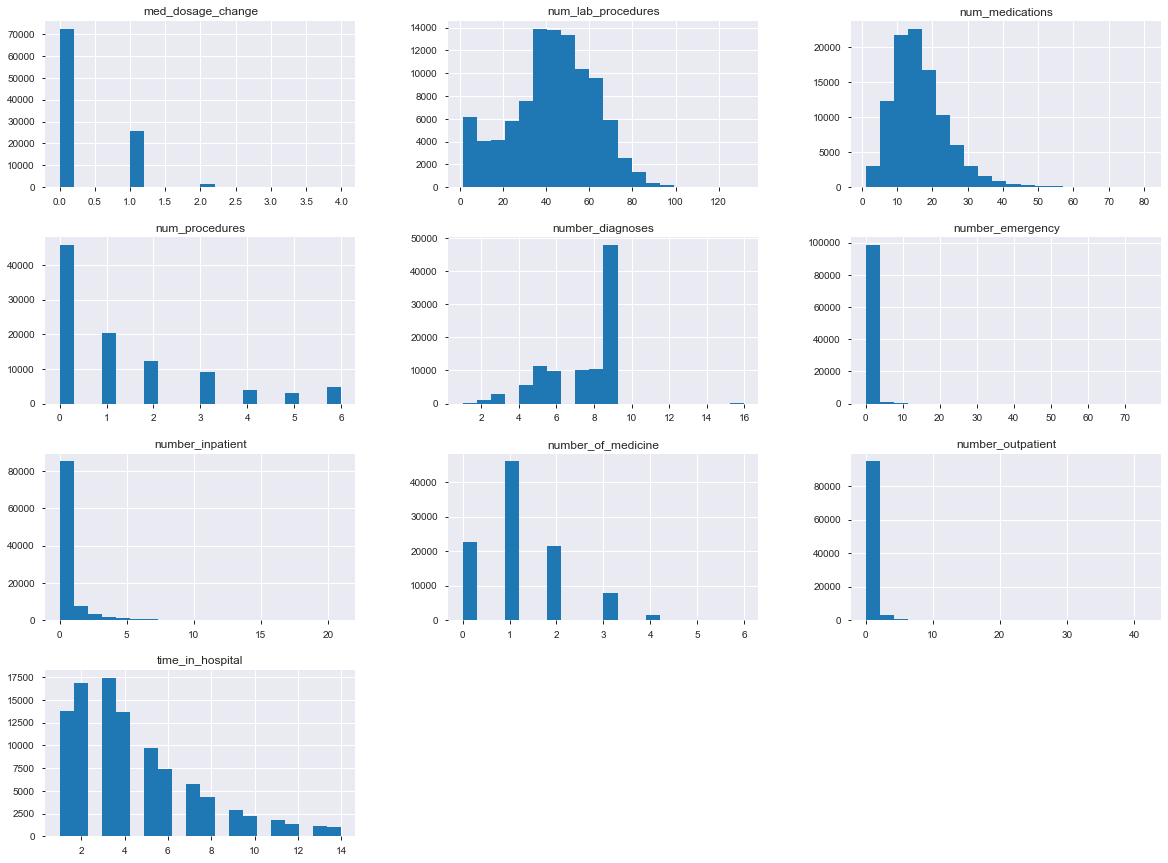

In [35]:
df_dummified[num_cols].hist(bins=20, figsize=(20,15))

In [42]:
# Removing skewnewss and kurtosis using log transformation if it is above a threshold value (2)

statdataframe = pd.DataFrame()
statdataframe['numeric_column'] = num_cols
skew_before = []
skew_after = []

kurt_before = []
kurt_after = []

standard_deviation_before = []
standard_deviation_after = []

log_transform_needed = []

log_type = []

for i in num_cols:
    skewval = df_dummified[i].skew()
    skew_before.append(skewval)
    
    kurtval = df_dummified[i].kurtosis()
    kurt_before.append(kurtval)
    
    sdval = df_dummified[i].std()
    standard_deviation_before.append(sdval)
    
    if (abs(skewval) >2) & (abs(kurtval) >2):
        log_transform_needed.append('Yes')
        
        if len(df_dummified[df_dummified[i] == 0])/len(df_dummified) <=0.02:
            log_type.append('log')
            skewvalnew = np.log(pd.DataFrame(df_dummified[train_data[i] > 0])[i]).skew()
            skew_after.append(skewvalnew)
            
            kurtvalnew = np.log(pd.DataFrame(df_dummified[train_data[i] > 0])[i]).kurtosis()
            kurt_after.append(kurtvalnew)
            
            sdvalnew = np.log(pd.DataFrame(df_dummified[train_data[i] > 0])[i]).std()
            standard_deviation_after.append(sdvalnew)
            
        else:
            log_type.append('log1p')
            skewvalnew = np.log1p(pd.DataFrame(df_dummified[df_dummified[i] >= 0])[i]).skew()
            skew_after.append(skewvalnew)
        
            kurtvalnew = np.log1p(pd.DataFrame(df_dummified[df_dummified[i] >= 0])[i]).kurtosis()
            kurt_after.append(kurtvalnew)
            
            sdvalnew = np.log1p(pd.DataFrame(df_dummified[df_dummified[i] >= 0])[i]).std()
            standard_deviation_after.append(sdvalnew)
            
    else:
        log_type.append('NA')
        log_transform_needed.append('No')
        
        skew_after.append(skewval)
        kurt_after.append(kurtval)
        standard_deviation_after.append(sdval)

statdataframe['skew_before'] = skew_before
statdataframe['kurtosis_before'] = kurt_before
statdataframe['standard_deviation_before'] = standard_deviation_before
statdataframe['log_transform_needed'] = log_transform_needed
statdataframe['log_type'] = log_type
statdataframe['skew_after'] = skew_after
statdataframe['kurtosis_after'] = kurt_after
statdataframe['standard_deviation_after'] = standard_deviation_after

statdataframe

numeric_column  skew_before  kurtosis_before  \
0    time_in_hospital     1.141746         0.887137   
1  num_lab_procedures    -0.241597        -0.252845   
2      num_procedures     1.322015         0.876153   
3     num_medications     1.335412         3.532965   
4   number_outpatient     8.838990       149.021609   
5    number_emergency    22.848383      1183.089951   
6    number_inpatient     3.633785        20.915687   
7    number_diagnoses    -0.861530        -0.121992   
8   med_dosage_change     1.427581         1.445214   
9  number_of_medicine     0.673919         0.273694   

   standard_deviation_before log_transform_needed log_type  skew_after  \
0                   2.968590                   No       NA    1.141746   
1                  19.610046                   No       NA   -0.241597   
2                   1.702873                   No       NA    1.322015   
3                   8.095274                   No       NA    1.335412   
4                   1.265265                  Yes    log1p    2.736732   
5                   0.937811                  Yes    log1p    3.666775   
6                   1.260469                  Yes    log1p    1.455312   
7                   1.941042                   No       NA   -0.861530   
8                   0.487885                   No       NA    1.427581   
9                   0.922387                   No       NA    0.673919   

   kurtosis_after  standard_deviation_after  
0        0.887137                  2.968590  
1       -0.252845                 19.610046  
2        0.876153                  1.702873  
3        3.532965                  8.095274  
4        7.826344                  0.429326  
5       16.333404                  0.315507  
6        1.422280                  0.509914  
7       -0.121992                  1.941042  
8        1.445214                  0.487885  
9        0.273694                  0.922387

In [43]:
# log transformation for the columns determined to be needing it above.

for i in range(len(statdataframe)):
    if statdataframe['log_transform_needed'][i] == 'Yes':
        colname = str(statdataframe['numeric_column'][i])
        
        if statdataframe['log_type'][i] == 'log':
            df = df[df[colname] > 0]
            df[colname + "_log"] = np.log(df[colname])
            
        elif statdataframe['log_type'][i] == 'log1p':
            df = df[df[colname] >= 0]
            df[colname + "_log1p"] = np.log1p(df[colname])

 Title: number_emergency
 Before Log Transformartion

 mu = 0.20 and sigma = 0.94



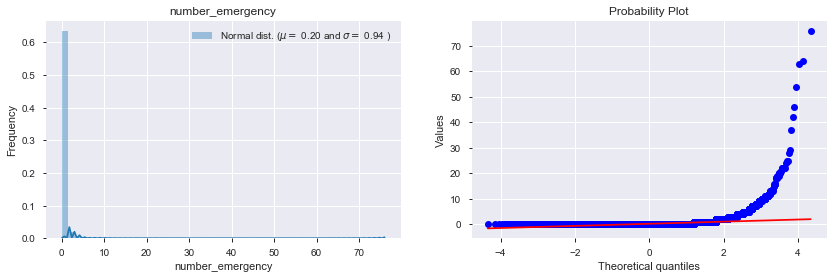

After Log Transformation

 mu = 0.10 and sigma = 0.32



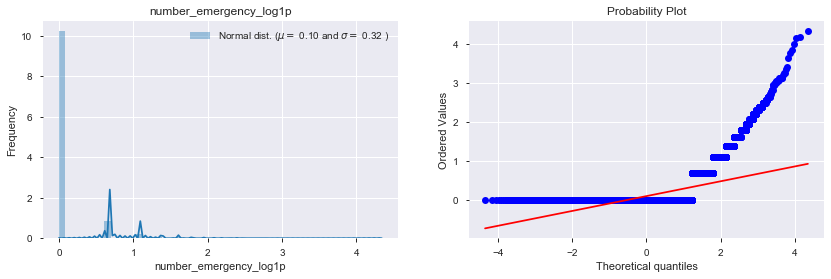

 Title: number_inpatient
 Before Log Transformartion

 mu = 0.63 and sigma = 1.26



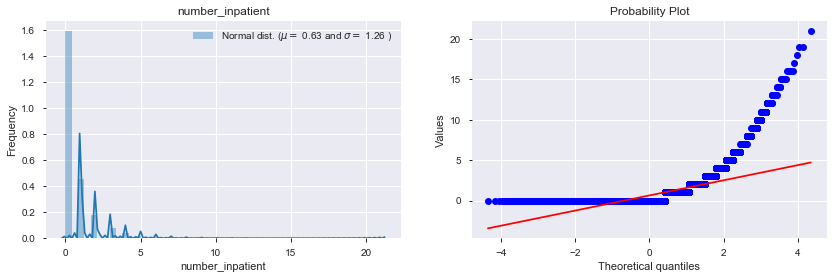

After Log Transformation

 mu = 0.32 and sigma = 0.51



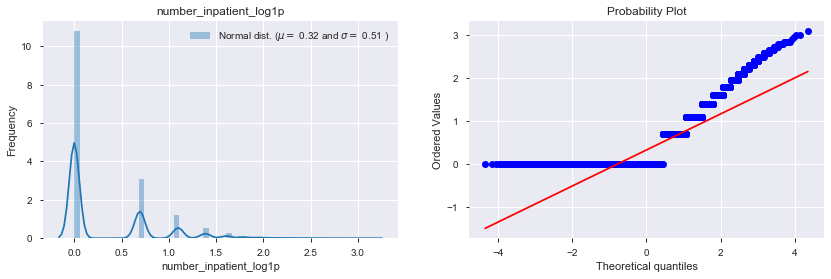

 Title: number_outpatient
 Before Log Transformartion

 mu = 0.37 and sigma = 1.27



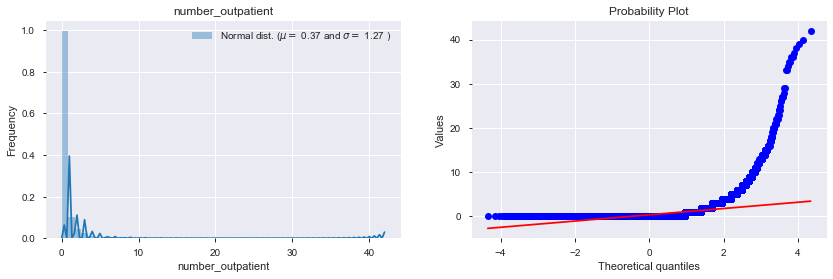

After Log Transformation

 mu = 0.17 and sigma = 0.43



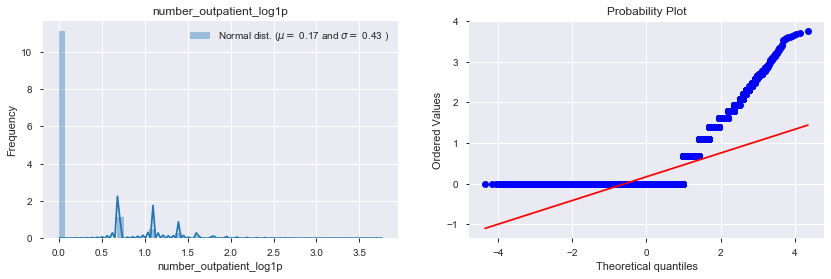

In [44]:
transform =['number_emergency','number_inpatient', 'number_outpatient']
Log_transform= ['number_emergency_log1p','number_inpatient_log1p', 'number_outpatient_log1p']

for i in range(0,3):
    print (" Title: %s" % transform[i])
    print (" Before Log Transformartion")
    fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(14, 4))

    sns.distplot(df[transform[i]], ax = ax1)

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[transform[i]])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Plot the distribution
    ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
    ax1.set_ylabel('Frequency')
    ax1.set_title(transform[i])

    #Get also the QQ-plot
    ax2 = plt.subplot(122)
    res = stats.probplot(df[transform[i]], plot=plt)
    ax2.set_ylabel('Values')
    plt.show()
    
    print( "After Log Transformation")
    
    fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(14,4))

    sns.distplot(df[Log_transform[i]], ax = ax1)

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[Log_transform[i]])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Plot the distribution
    ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
    ax1.set_ylabel('Frequency')
    ax1.set_title(Log_transform[i])

    #Get also the QQ-plot
    ax2 = plt.subplot(122)
    res = stats.probplot(df[Log_transform[i]], plot=plt)
    plt.show()
    



In [45]:
df_dummified.select_dtypes(include=['int64','float64']).columns.tolist()

['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'med_dosage_change',
 'number_of_medicine',
 'number_outpatient_log1p',
 'number_emergency_log1p',
 'number_inpatient_log1p']

In [46]:
#drop number_outpatient, number_emergency, number_inpatient
df_dummified = df_dummified.drop(['number_outpatient', 'number_emergency','number_inpatient'], axis = 1)



In [47]:
new_num_cols = df_dummified.select_dtypes(include=['int64','float64']).columns.tolist()


In [48]:
# standardize function
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [49]:
df_dummified[new_num_cols] = standardize(df_dummified[new_num_cols])
import scipy.stats as sp
df_dummified = df_dummified[(np.abs(sp.zscore(df_dummified[new_num_cols])) < 3).all(axis=1)]


In [50]:
import seaborn as sns
from matplotlib.colors import ListedColormap

my_cmap = ListedColormap(sns.light_palette((250, 100, 50), input="husl", n_colors=50).as_hex())
# drop some columns due to their means is round to 0
#table = df.drop(['acetohexamide','tolbutamide', 'troglitazone', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone','patient_nbr', 'encounter_id', 'service_utilization_log1p'], axis = 1).corr(method='pearson')
table = df_dummified.drop(['patient_nbr', 'encounter_id'], axis=1).corr(method='pearson')
table.style.background_gradient(cmap=my_cmap, axis = 0)

In [51]:
df_train_cleaned = df_dummified[df_dummified.dataset=='train']
df_train_cleaned = df_dummified.drop(columns='dataset')
df_test_cleaned = df_dummified[df_dummified.dataset=='test']
df_test_cleaned = df_dummified.drop(columns='dataset')


df_train_cleaned.to_csv('./df_whole_train_cleaned.csv', index=False)
df_test_cleaned.to_csv('./df_whole_test_cleaned.csv', index=False)


In [52]:
encounter_frequency = pd.DataFrame(df_dummified.patient_nbr.value_counts())
encounter_frequency = encounter_frequency.reset_index()
encounter_frequency.rename(columns = {'index':'patient_nbr', 'patient_nbr':'encounter_frequency'}, inplace = True) 
encounter_frequency.patient_nbr = encounter_frequency.patient_nbr.astype('object')
encounter_frequency

patient_nbr  encounter_frequency
0        90164655                   13
1        42915474                   13
2        92709351                   12
3        30224430                   12
4        40595031                   12
5        40373325                   12
6        84428901                   11
7        41717169                   11
8        95652576                   11
9        89710911                   11
10       42567840                   11
11       80811567                   11
12       93690234                   10
13       23481783                   10
14        8041437                   10
15       37072377                   10
16       86931513                   10
17        3227184                   10
18       15749334                   10
19         276606                   10
20       41220999                   10
21       86186484                   10
22       41843502                   10
23      112563099                    9
24       39911247                    9
25       29401542                    9
26        1158318                    9
27       67687461                    9
28       91394082                    9
29       40958892                    9
30       24011577                    9
31       91945008                    9
32       43417926                    9
33       41699412                    9
34       84428613                    9
35       41777082                    9
36      114262794                    9
37       88898445                    9
38         510255                    9
39        4042314                    9
40       86765814                    9
41       85295430                    9
42       93086505                    9
43      110463471                    9
44      102847392                    9
45       57902751                    9
46          30735                    9
47       58752171                    9
48       85495860                    9
49       77554278                    9
50       41073129                    9
51         384939                    9
52       84492585                    9
53      108954081                    9
54       41041530                    9
55       85061286                    9
56       94062717                    9
57       23233860                    9
58       42031656                    9
59        1530720                    9
60       41346216                    9
61       23539905                    8
62        1665054                    8
63      109275102                    8
64       91000287                    8
65       45305631                    8
66         107460                    8
67        3611988                    8
68       41658057                    8
69        3538080                    8
70       40816332                    8
71       23233167                    8
72       99811971                    8
73       91853226                    8
74       88410879                    8
75       43332093                    8
76      105799356                    8
77       96185673                    8
78       41615262                    8
79       85523634                    8
80        2120220                    8
81       85232619                    8
82        1227087                    8
83       84382974                    8
84       84397842                    8
85       88533495                    8
86       47946168                    8
87       41172228                    8
88       13377636                    8
89       40825989                    8
90       23464449                    8
91          45144                    8
92        1845423                    8
93       91885185                    8
94          13041                    8
95       16516467                    8
96       88780527                    8
97       97802892                    8
98       91581660                    8
99       86084703                    8
100      91562562                    8
101       4103964           

In [53]:
df_dummified_unique = df_dummified.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df_dummified_unique.shape
#df_dummified_unique will drop all multiple encounter, only keep 1

(64897, 79)

In [54]:
df_dummified_unique = pd.merge(df_dummified_unique, encounter_frequency, left_on='patient_nbr', right_on='patient_nbr')


In [55]:
df_dummified_unique

encounter_id patient_nbr  time_in_hospital  num_lab_procedures  \
0          7733208     3291489         -0.801560            0.412639   
1        152449578    84529188         -0.464698            2.197448   
2        440311646   121372727          2.903921            2.299437   
3        139779162    86645961         -0.464698           -1.066202   
4        223277988    59559255          0.209026            1.279546   
5        127005696    72034335         -0.127836            1.177557   
6         37320456    23560803          0.545888           -1.321175   
7        144033276     6382269         -0.801560            0.004683   
8        166008048    89445645         -0.801560            0.463634   
9        255458850    84752271         -0.127836            2.044464   
10        80899056    21250872         -0.127836            0.106672   
11        30278250    74280573          0.545888            0.922585   
12        25723410      105264         -0.801560            0.055678   
13       141789846   110455767         -0.127836           -0.811229   
14       408994352    73577808         -0.801560            0.667612   
15       125648112    94077981         -0.464698           -0.199295   
16       298992920   124159298          0.882750            0.412639   
17       220854444    93060729          2.567059            0.412639   
18       179197776    84942891         -0.464698            0.310650   
19       221059440   103600854          0.545888            0.820595   
20       425471630    95393196         -0.127836           -0.046311   
21       399707912    39461355          1.219612           -0.199295   
22        72013248    10198332         -1.138422           -2.137087   
23        90337758     2707740          0.882750            0.565623   
24       118141596    24596334         -0.127836            0.004683   
25        71577678     4251447          0.545888            0.157667   
26       281853666    38495268          2.230197            0.820595   
27       409648886   110122794         -0.801560           -0.760235   
28       190937352    69394374         -0.801560           -1.015207   
29       183858066    86552244         -0.801560           -2.137087   
30        39488220    24115194         -0.127836           -0.913218   
31       286487718    41211549         -1.138422           -0.709240   
32       251906046    43059276          0.882750           -0.556257   
33        79736694    21148506         -0.801560            0.922585   
34        32908302    26109666         -1.138422           -1.219186   
35       244311678    31774032         -1.138422           -1.678136   
36       155785044    85067748         -0.464698            0.871590   
37       228073746   110478492         -0.464698           -0.760235   
38       149372034    38806146         -0.464698           -0.658246   
39       100914072    79610292          0.545888            1.177557   
40       393139334    66095937         -0.464698           -0.250290   
41       120793272    94691709          0.545888           -2.137087   
42       307879730    37755162         -0.801560            0.463634   
43       258435180    41918265          0.545888            1.534519   
44       379126592   139451207          2.903921           -0.097306   
45        52139178    19829754          1.893335           -0.862224   
46        70438542    55784322          0.882750            1.381535   
47       119384640    24923016          1.556474           -0.097306   
48       112928466    23463990          1.219612            0.106672   
49       300185774    90674217          0.209026            1.840486   
50        66394284    20508453         -0.464698           -1.168191   
51       247773258    54698949         -0.801560           -0.046311   
52       185321418    60136974          1.219612            0.157667   
53        58389702    26006670         -0.801560           -1.321175   
54       443120228    86215806         -0.1278

In [56]:
df_dummified_unique_train = df_dummified_unique[df_dummified_unique.dataset=='train']
df_dummified_unique_train = df_dummified_unique_train.drop(columns='dataset')
df_dummified_unique_test = df_dummified_unique[df_dummified_unique.dataset=='test']
df_dummified_unique_test = df_dummified_unique_test.drop(columns='dataset')


df_dummified_unique_test.to_csv('./df_unique_test_cleaned.csv', index=False)
df_dummified_unique_train.to_csv('./df_unique_train_cleaned.csv', index=False)

In [57]:
df_dummified.shape

(88008, 79)

In [58]:
summarize_feature(df_dummified_unique, 'readmitted')

values  counts  frequency
0      0   60090   0.925929
1      1    4807   0.074071

In [59]:
summarize_feature(df_dummified, 'readmitted')

values  counts  frequency
0      0   78564   0.892692
1      1    9444   0.107308